<a href="https://colab.research.google.com/github/ZahraAlebouye/pointnet/blob/main/pointnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
from torch.utils.data import DataLoader

In [2]:
class ModelNet40Dataset(torch.utils.data.Dataset):
    def __init__(self,data_dir, split='train'):
        self.data=np.load(os.path.join(data_dir,f'{split}_data.npy'))
        self.labels = np.load(os.path.join(data_dir, f'{split}_labels.npy'))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        points=self.data[idx]
        label=self.labels[idx]
        points=torch.from_numpy(points).float()
        label=torch.tensor(label).long()
        return points,label

In [ ]:
/content/train_data.npy

In [3]:
data_dir ='/content'

In [4]:
train_dataset = ModelNet40Dataset(data_dir, split='train')

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
class PointNetCls(nn.Module):
    def __init__(self, k=40):
        super(PointNetCls, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Input: (batch_size, num_points, 3)
        x = x.transpose(2, 1)  # to (batch_size, 3, num_points)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2)[0]  # Global max pooling
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

In [9]:
model = PointNetCls(k=40).to(device)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
criterion = nn.NLLLoss()

In [12]:
n_epochs = 10

In [29]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for points, labels in dataloader:
            points, labels = points.to(device), labels.to(device)
            outputs = model(points)
            loss = criterion(outputs, labels)
            preds = outputs.max(1)[1]
            total_correct += preds.eq(labels).sum().item()
            total_loss += loss.item()
    acc = total_correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, acc

In [30]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


In [31]:
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [32]:
# Best model tracking
best_val_acc = 0

In [34]:
test_dataset = ModelNet40Dataset(data_dir, split='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [35]:
for epoch in range(n_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for points, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}'):
        points, labels = points.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(points)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.max(1)[1]
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    # Scheduler step
    scheduler.step()

    # Evaluate on validation set (use your test_loader)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    # Logging
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f'Epoch [{epoch+1}/{n_epochs}] Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')

    # Save best model checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f'✅ Best model saved at Epoch {epoch+1} with Val Acc: {val_acc:.4f}')

print('🎉 Training complete.')

Epoch 1/10: 100%|██████████| 189/189 [00:04<00:00, 45.14it/s]


Epoch [1/10] Train Loss: 2.0867 Train Acc: 0.4112 Val Loss: 5.4668 Val Acc: 0.0659
✅ Best model saved at Epoch 1 with Val Acc: 0.0659


Epoch 2/10: 100%|██████████| 189/189 [00:04<00:00, 44.87it/s]


Epoch [2/10] Train Loss: 2.0817 Train Acc: 0.4125 Val Loss: 5.2809 Val Acc: 0.0659


Epoch 3/10: 100%|██████████| 189/189 [00:04<00:00, 41.52it/s]


Epoch [3/10] Train Loss: 2.0573 Train Acc: 0.4155 Val Loss: 5.1191 Val Acc: 0.0659


Epoch 4/10: 100%|██████████| 189/189 [00:04<00:00, 44.80it/s]


Epoch [4/10] Train Loss: 2.0308 Train Acc: 0.4268 Val Loss: 5.2534 Val Acc: 0.0659


Epoch 5/10: 100%|██████████| 189/189 [00:04<00:00, 43.39it/s]


Epoch [5/10] Train Loss: 2.0085 Train Acc: 0.4254 Val Loss: 5.3894 Val Acc: 0.0659


Epoch 6/10: 100%|██████████| 189/189 [00:04<00:00, 45.15it/s]


Epoch [6/10] Train Loss: 1.9653 Train Acc: 0.4395 Val Loss: 5.9433 Val Acc: 0.0112


Epoch 7/10: 100%|██████████| 189/189 [00:04<00:00, 45.54it/s]


Epoch [7/10] Train Loss: 1.9742 Train Acc: 0.4339 Val Loss: 5.6001 Val Acc: 0.0105


Epoch 8/10: 100%|██████████| 189/189 [00:04<00:00, 43.73it/s]


Epoch [8/10] Train Loss: 1.9502 Train Acc: 0.4403 Val Loss: 4.6716 Val Acc: 0.0132


Epoch 9/10: 100%|██████████| 189/189 [00:04<00:00, 42.98it/s]


Epoch [9/10] Train Loss: 1.9126 Train Acc: 0.4471 Val Loss: 4.7267 Val Acc: 0.0461


Epoch 10/10: 100%|██████████| 189/189 [00:04<00:00, 44.51it/s]


Epoch [10/10] Train Loss: 1.8874 Train Acc: 0.4595 Val Loss: 5.0207 Val Acc: 0.0461
🎉 Training complete.


In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [15]:
def visualize_point_cloud(points, title='Point Cloud', color='b'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5, c=color)
    ax.set_title(title)
    plt.show()

In [44]:
points, labels = next(iter(train_loader))
points = points[0].cpu().numpy()  # Pick one sample
label = labels[0].item()

In [45]:
label

13

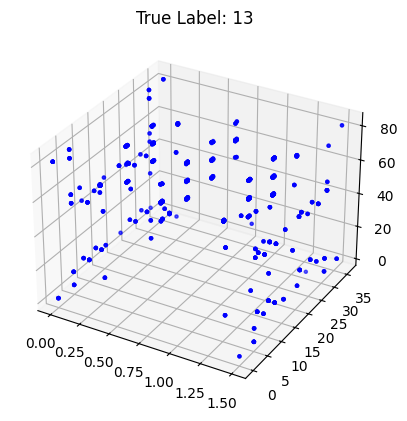

In [46]:
# Visualize input point cloud
visualize_point_cloud(points, title=f'True Label: {label}')

In [38]:
model.eval()
with torch.no_grad():
    pred = model(points.to(device))  # (batch_size, num_classes)
    pred_labels = pred.max(1)[1]     # (batch_size,)
    print(pred_labels)  # Tensor of predicted labels for the batch


tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


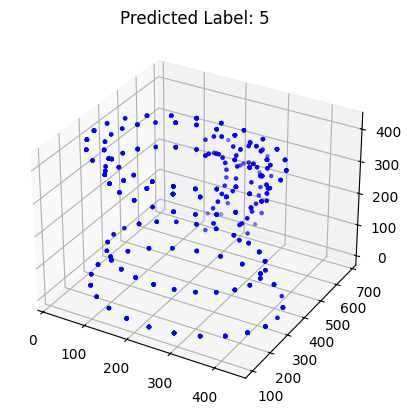

In [43]:
# Assuming points is a batch: (batch_size, 1024, 3)
points_batch, labels_batch = next(iter(train_loader))

# Pick the first sample from the batch
points_single = points_batch[0]  # (1024, 3)

# Predict the label for this single sample
model.eval()
with torch.no_grad():
    pred = model(points_single.unsqueeze(0).to(device))  # Add batch dimension: (1, 1024, 3)
    pred_label = pred.max(1)[1].item()

# Visualize the point cloud with predicted label in the title
visualize_point_cloud(points_single.cpu().numpy(), title=f'Predicted Label: {pred_label}')


In [39]:
single_point = points[0].unsqueeze(0).to(device)  # (1, 1024, 3)

In [40]:
single_point

tensor([[[ 1.8024, -3.0466, 63.3586],
         [ 2.4388, -3.3873, 64.7812],
         [ 1.1785, -3.4255, 65.9675],
         ...,
         [ 8.3665,  3.5047, 27.1350],
         [11.5471,  6.3655, 48.8852],
         [-4.1422,  0.7486, 26.7204]]], device='cuda:0')

In [41]:
with torch.no_grad():
    pred = model(single_point)  # (1, num_classes)
    pred_label = pred.max(1)[1].item()
    print(f'Predicted label: {pred_label}')

Predicted label: 5


In [24]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  

In [25]:
import open3d as o3d

In [26]:
def visualize_point_cloud_open3d(points, color=[0, 0.5, 0.5]):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.paint_uniform_color(color)
    o3d.visualization.draw_geometries([pcd])

In [27]:
visualize_point_cloud_open3d(points)

[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
class TNet(nn.Module):
    def __init__(self, k=3):
        super(TNet, self).__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2)[0]

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        id_matrix = torch.eye(self.k, device=x.device).flatten().unsqueeze(0).repeat(batch_size, 1)
        x = x + id_matrix
        x = x.view(-1, self.k, self.k)
        return x

In [ ]:
class SharedMLP(nn.Module):
    def __init__(self, mlp_sizes):
        super(SharedMLP, self).__init__()
        layers = []
        for i in range(len(mlp_sizes) - 1):
            layers.append(nn.Conv1d(mlp_sizes[i], mlp_sizes[i+1], 1))
            layers.append(nn.BatchNorm1d(mlp_sizes[i+1]))
            layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


In [ ]:
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, k):
        super(ClassificationHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [ ]:
class PointNetClassifier(nn.Module):
    def __init__(self, k=40):
        super(PointNetClassifier, self).__init__()
        self.input_transform = TNet(k=3)
        self.shared_mlp1 = SharedMLP([3, 64])
        self.feature_transform = TNet(k=64)  # Feature T-Net
        self.shared_mlp2 = SharedMLP([64, 128, 1024])
        self.classifier = ClassificationHead(1024, k)

    def forward(self, x):
        # Input: (batch_size, num_points, 3)
        x = x.transpose(2, 1)  # (batch_size, 3, num_points)

        # Input Transform
        transform = self.input_transform(x)  # (batch_size, 3, 3)
        x = torch.bmm(transform, x)  # Apply transform

        # First MLP block
        x = self.shared_mlp1(x)  # (batch_size, 64, num_points)

        # Feature Transform
        transform_feat = self.feature_transform(x)  # (batch_size, 64, 64)
        x = torch.bmm(transform_feat, x)  # Apply feature transform

        # Second MLP block + Global pooling
        x = self.shared_mlp2(x)  # (batch_size, 1024, num_points)
        x = torch.max(x, 2)[0]   # (batch_size, 1024)

        # Classification Head
        out = self.classifier(x)
        return out